# Critical Mineral Screening tool

The critical minerals screening tool evaluates whether a given produced water network has the potential for critical mineral recovery. Here we focus on lithium given that it is one of the most abundant elements present in produced water.
In this notebook we will learn how to use the screening tool to answer the following questions:
1. Does current infrastructure and placement of the treatment site facilitate lithium recovery?
2. Is the current infrastructure hindering critical mineral recovery opportunities?
3. What is the optimal location to install the treatment facility within the network?


Module Overview:
1. Load and view data
2. Run current model
3. Run a comparison between the maximum theoretical revenue with and without existing infrastructure
4. Identify the optimal location for desalination installation


In [ ]:
#####################################################################################################
# PARETO was produced under the DOE Produced Water Application for Beneficial Reuse Environmental
# Impact and Treatment Optimization (PARETO), and is copyright (c) 2021-2024 by the software owners:
# The Regents of the University of California, through Lawrence Berkeley National Laboratory, et al.
# All rights reserved.
#
# NOTICE. This Software was developed under funding from the U.S. Department of Energy and the U.S.
# Government consequently retains certain rights. As such, the U.S. Government has been granted for
# itself and others acting on its behalf a paid-up, nonexclusive, irrevocable, worldwide license in
# the Software to reproduce, distribute copies to the public, prepare derivative works, and perform
# publicly and display publicly, and to permit others to do so.
#####################################################################################################

## Imports
import pyomo.environ as pyo
from pareto.models_extra.CM_module.models.qcp_br import build_qcp_br
from pareto.utilities.get_data import get_data
from pareto.models_extra.CM_module.cm_utils.gen_utils import report_results_to_excel
from pareto.models_extra.CM_module.cm_utils.opt_utils import (
    max_theoretical_recovery_flow_opt,
    cost_optimal,
    max_recovery_with_infrastructure,
)
from pareto.models_extra.CM_module.cm_utils.run_utils import (
    load_data,
    print_results_summary,
    solving,
    node_rerun,
)
from pareto.models_extra.CM_module.cm_utils.data_parser import data_parser

from importlib import resources

In this notebook we will show the implementation of the screening tool on CM_small_permian.xlsx, which is based on PARETO's strategic toy case study. You can also run the problem on another provided case study, large_case_study_Li.xlsx, or develop your own case study.

In [ ]:
# Loading data
# In this problem we are going to use the small case study
with resources.path(
    "pareto.models_extra.CM_module.case_studies",
    "CM_small_permian.xlsx",  # change this to large_case_study_Li if you want to try the other case study
) as fpath:
    # Obtaining data from excel file
    [df_sets, df_parameters] = get_data(fpath, model_type="critical_mineral")

# Parsing the data to make it in the model format
data = data_parser(df_sets, df_parameters)

## Base case

In this section we will show how the model performs on the pre-loaded base case with the desalination facility installed next to node N03. 
The goal of this model is to minimize operating costs given possible lithium recovery revenue and beneficial reuse revenue while ensuring that at every time period at least 100 mg/L Li concentrated water exits the desalination facility.

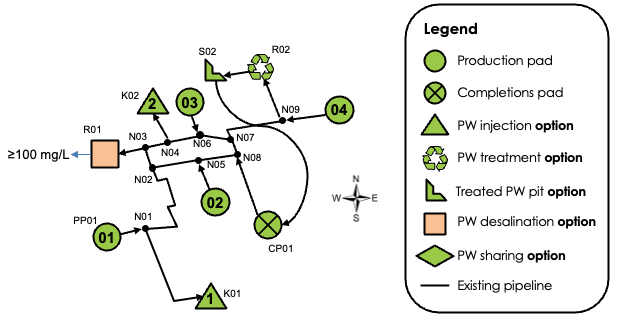

In [ ]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(model, tee=False)  # make tee=True if you want to see solver logs

The model solved successfully which means that lithium recovery opportunities exist given the current infrastructure. Now we will try to assess whether more lithium revenue is possible.

## Assessing critical mineral revenue possibilities

In this section we assess whether the current infrastructure is maximizing critical mineral recovery opportunities.

In the next block we will rerun the model, but this time to maximize critical mineral revenue without considering the impact that it has on other operating costs.

In [ ]:
max_inf_model = max_recovery_with_infrastructure(data)
print_results_summary(max_inf_model)

Now we will compare this amount to the maximum theoretical Li revenue that can be obtained from this network if we disregard the existing infrastructure. This means we will compare the maximum Critical Mineral revenue that can be obtained given existing infrastructure and maximum critical mineral revenue if no infrastructure existed. The latter is a calculation that uses the production pad CM concentration levels to evaluate the maximum critical mineral revenue.

In [ ]:
# calculate max theoretical CM revenue from network when disregarding existing infrastructure
cm_name = "Li"
max_recovery = max_theoretical_recovery_flow_opt(
    model,
    desal_unit="R01_IN",  # change R01 if you want to consider a different treatment unit
    cm_name=cm_name,
    desired_cm_conc=100,
)

# Displaying the difference between max possible lithium revenue with and without existing infrastructure
print(
    f"Max. critical mineral revenue with\n existing infrastructure:  "
    f"{pyo.value(max_inf_model.treat_rev):>8.0f}"
)
print()
print(
    f"Max. theoretical {cm_name} revenue\n (ignoring infrastructure): "
    f"{max_recovery:>8.0f}"
)

We can see that there is quite a difference in the critical mineral revenue being generated in each case.

## Optimal treatment facility location
What if we want to see which node within the network is the best location for installing the desalination facility?
In this section, we show how our model can tell the user which is the best location to install the desalination facility. We rerun the operational model by attaching the specified desalination facility at each node of the network. At the end, we compare which node led to the minimum costs.

Warning: This problem can take a long time to run. The small case study takes 8-10 minutes and the large case study takes 20-25 minutes.

In [ ]:
min_node, models = node_rerun(
    df_sets, df_parameters, treatment_site="R01", max_iterations=5000
)
final_model = models[min_node]
print()
print(f"*** Lowest cost location for treatment ***")

# Displaying specific broken down costs
print_results_summary(final_model)

It turns out that the initial location of the desalination facility next to node N03 is suboptimal. Rather, N06 is the optimal installation location. This makes sense because N06 is next to a high lithium concentration production pad.

### Storing results

We can save the flow, concentration, and inventory results in an Excel file within the current directory.

In [ ]:
fname = "CM_small_permian"

# change final_model to any model you want to store. Here we store
report_results_to_excel(
    final_model, filename=f"{fname}_operational_results.xlsx", split_var={"s_A": 3}
)
print("Results saved")

## Let's talk about infeasibility

There can be cases where the model is infeasible. Let's examine the output for such a case.



We will change the minimum lithium concentration requirement. First, let's look at what the existing requirement is.

In [ ]:
# We will change the minimum lithium concentration requirement to force infeasibility
print(data["p_Cmin"])

On the backend, we change the treatment facility to a three-node network as shown below. R01_CW stands for the concentrated water stream exiting the treatment facility.

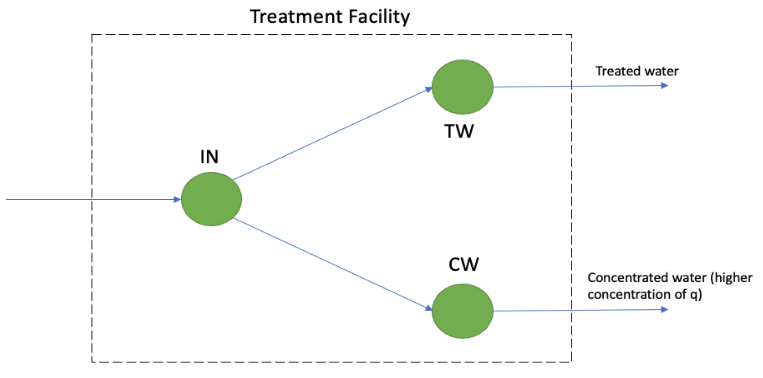

Now let's change the minimum Li concentration from 100 to 150 for R01:

In [ ]:
data["p_Cmin"]["R01_CW", "Li"] = 150
print(data["p_Cmin"])

In [ ]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(
    model, tee=False, inf_recs=True
)  # make inf_recs=False if you don't want to see feasibility recommendations

This model turned out to be infeasible. In produced water networks the infeasibility usually arises due to the minimum concentration constraint. If the model is infeasible we provide recommendations on how to obtain feasibility.